In [247]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from random import randint
from IPython.display import Image, display
import sys
import json

In [248]:
image = 'D:/5sem/MRZvIS/laba1/dog.png'
enc = 'D:/5sem/MRZvIS/laba1/encoded.png'
dec = 'D:/5sem/MRZvIS/laba1/decoded.png'
picture = mpimg.imread(image)
images_num = 1000

In [249]:
def display_image(image):
    display(Image(filename=image)) 

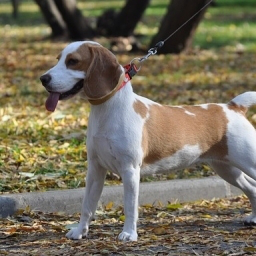

In [250]:
display_image(image)

In [251]:
def shape_parameters(image):
    img_parameters = mpimg.imread(image).shape
    mult_parameters = 1
    for i in img_parameters:
        mult_parameters *= i
    return img_parameters, mult_parameters

In [252]:
print(shape_parameters(image))
img_size = shape_parameters(image)[0][1]
factors_calc_param = len(shape_parameters(image)[0])
print(factors_calc_param)

((256, 256, 3), 196608)
3


In [253]:
def block_parameters(block_rows, block_cols):
    horiz_blocks = img_size//block_rows
    vert_blocks = img_size//block_cols
    blocks_count = (img_size//block_rows)*(img_size//block_cols)
    return horiz_blocks, vert_blocks, blocks_count

In [254]:
block_rows = int(input())
block_cols = int(input())
horizontal, vertical, blocks_num = block_parameters(block_rows, block_cols)

In [255]:
def upload_weights():
        W1 = np.loadtxt(open('D:/5sem/MRZvIS/laba1/w1.csv'), delimiter=",")
        W2 = np.loadtxt(open('D:/5sem/MRZvIS/laba1/w2.csv'), delimiter=",")
        return W1, W2

In [256]:
data = np.zeros((blocks_num*images_num, block_rows*block_cols*3))
reshape_factor = (block_rows + block_cols)//(factors_calc_param+block_rows/2)
print(reshape_factor)
for img in range(images_num):
    for col in range(vertical):
        for row in range(horizontal):
            data[blocks_num*img+horizontal*col+row,:] = picture[block_cols*col:block_cols*(col+1),block_rows*row:block_rows*(row+1),:].reshape(block_rows*block_cols*3)*reshape_factor-1

2


In [257]:
def weights_normalization():
    global W1
    normalize_range = range(len(W1[0]))
    normalize_factor = 2
    normalize_ratio = 0.5
    normalize_arr = []
    for _ in normalize_range:
        normalize_arr.append(0)
    for row in range(len(W1)):
        filling_range = range(len(W1[row]))
        for col in filling_range:
           normalize_arr[col] += W1[row][col] ** normalize_factor
    for row in range(len(normalize_arr)):
        normalize_arr[row] = normalize_arr[row] ** (0.5)
    for row in range(len(W1)):
        for col in range(len(W1[row])):
           W1[row][col] /= normalize_arr[col]

In [258]:
def get_weights_and_alpha(block_rows, block_cols, compression_ratio):
    load_switcher = int(input())
    global W1
    global W2
    if load_switcher == 1:
        W1 = np.random.normal(0.0, pow(3*block_cols*block_rows//compression_ratio, -0.5),(3*block_cols*block_rows,3*block_cols*block_rows//compression_ratio))
        weights_normalization()
        W2 = W1.T
    else: 
        W1,W2 = upload_weights()
    alpha = 5*10e-5
    return W1, W2, alpha

In [259]:
W1, W2, alpha = get_weights_and_alpha(block_rows, block_cols, compression_ratio = 3)

In [260]:
def network_training(pic):
    global W1
    global W2
    global alpha
    compressed = (pic@W1)[np.newaxis]
    output = (compressed@W2)
    error = (output - pic)
    W2 -=  alpha*(compressed.T@error)
    pic = pic[np.newaxis]
    W1 -= alpha*pic.T@error@W2.T
    return error

In [261]:
def encode(pic):
    global W1
    reshape_factor = (block_rows + block_cols)//(factors_calc_param+(block_rows/2))
    print(reshape_factor)
    splitted_pic = []
    #split image into squares
    for col in range(vertical):
            for row in range(horizontal):
                splitted_pic.append(pic[block_cols*col:block_cols*(col+1),block_rows*row:block_rows*(row+1),:].reshape(block_rows*block_cols*3)*reshape_factor-1)
    encoded_pic = []
    #encode pic
    for i in splitted_pic:
        encoded_pic.append(i@W1)
    return np.array(encoded_pic)

In [262]:
def decode(encoded):
    global W2
    decode_rows, decode_cols = img_size, img_size
    reshape_first_param, reshape_second_param = block_rows, block_rows
    pic = np.zeros((decode_rows,decode_cols,3))
    for col in range(vertical):
        for row in range(horizontal):
            pic[col*block_cols:(col+1)*block_cols,row*block_rows:(row+1)*block_rows] = (encoded[col*block_cols+row]@W2).reshape(reshape_first_param,reshape_second_param,3)
    picture_calc_factor = factors_calc_param - 1
    pic = (pic+1)/picture_calc_factor
    return pic

In [263]:
def test_pic(pic):
    return decode(encode(pic))

In [264]:
trainings_num = 1000
training = data[:trainings_num]

In [265]:
for img in training:
    network_training(img)

In [266]:
#weight save
first_weights_path = 'D:/5sem/MRZvIS/laba1/w1.csv'
second_weights_path = 'D:/5sem/MRZvIS/laba1/w2.csv'
np.savetxt(first_weights_path, W1, delimiter=',')
np.savetxt(second_weights_path, W2, delimiter=',')

2
2


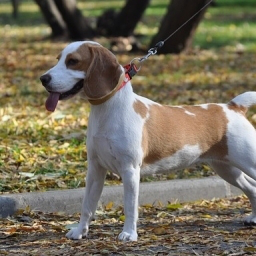

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


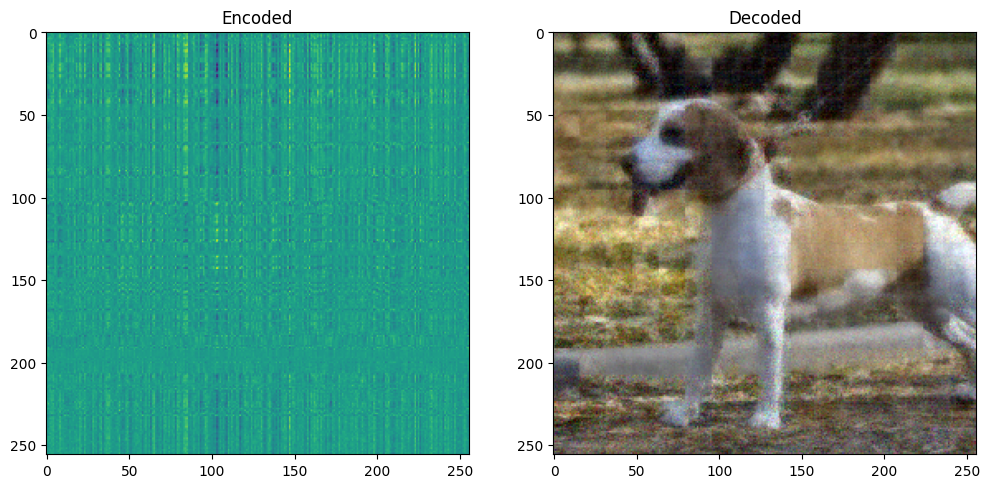

In [270]:
matplotlib.rcParams['figure.figsize'] = [12, 12]

pic_num = randint(1,1000)
encoded_pic = encode(picture)
test = test_pic(picture)


display_image(image)
fig, axs = plt.subplots(1,2)
axs[0].imshow(encoded_pic)
axs[1].imshow(test)
axs[0].set_title("Encoded")
axs[1].set_title("Decoded")
